**Churn analysis of banking customers**


Dataset shape: (10000, 13)

First few rows:
           CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
RowNumber                                                                     
1            15634602  Hargrave          619    France  Female   42       2   
2            15647311      Hill          608     Spain  Female   41       1   
3            15619304      Onio          502    France  Female   42       8   
4            15701354      Boni          699    France  Female   39       1   
5            15737888  Mitchell          850     Spain  Female   43       2   

             Balance  NumOfProducts  HasCrCard  IsActiveMember  \
RowNumber                                                        
1               0.00              1          1               1   
2           83807.86              1          0               1   
3          159660.80              3          1               0   
4               0.00              2          0               0   
5     

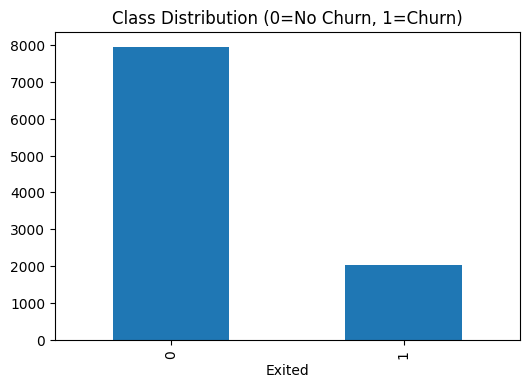


=== FEATURE PREPARATION ===
Features used: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_encoded', 'Gender_encoded']
Feature matrix shape: (10000, 10)
Training set: 8000 samples
Test set: 2000 samples
Training churn rate: 0.204
Test churn rate: 0.203

=== MODEL TRAINING ===

=== MODEL EVALUATION ===
Accuracy: 0.8050
ROC-AUC Score: 0.7710

Confusion Matrix:
[[1552   41]
 [ 349   58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.14      0.23       407

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.81      0.75      2000


=== FEATURE IMPORTANCE ===
             feature  coefficient  abs_coefficient
1                Age     0.739402         0.739402
6     IsActiveMember    -0.519640         0.519640
3    

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv(r"C:\Users\sorin.creanga\Downloads\Churn_Modelling.csv", index_col=0)
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Basic data exploration
print("\n=== DATA EXPLORATION ===")
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nChurn rate:")
print(df['Exited'].value_counts(normalize=True))

# Check for class imbalance
plt.figure(figsize=(6, 4))
df['Exited'].value_counts().plot(kind='bar')
plt.title('Class Distribution (0=No Churn, 1=Churn)')
plt.show()

# Store identity data BEFORE dropping columns
identity_data = df[["CustomerId", "Surname", "Geography", "Gender"]].copy()

# Prepare features
print("\n=== FEATURE PREPARATION ===")
# Encode categorical variables properly
le_geo = LabelEncoder()
le_gender = LabelEncoder()

df['Geography_encoded'] = le_geo.fit_transform(df['Geography'])
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])

# Select features (keep both numeric and encoded categorical)
feature_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                  'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 
                  'Geography_encoded', 'Gender_encoded']

X = df[feature_columns]
y = df['Exited']

print("Features used:", feature_columns)
print("Feature matrix shape:", X.shape)

# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training churn rate: {y_train.mean():.3f}")
print(f"Test churn rate: {y_test.mean():.3f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
print("\n=== MODEL TRAINING ===")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("\n=== MODEL EVALUATION ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Get test set indices for identity matching
test_indices = X_test.index

# Create results dataframe with customer information
results_df = identity_data.loc[test_indices].copy()
results_df['Actual_Churn'] = y_test.values
results_df['Predicted_Churn'] = y_pred
results_df['Churn_Probability'] = y_proba

# Top 10 customers at highest churn risk
print("\n=== HIGH RISK CUSTOMERS ===")
high_risk = results_df.sort_values('Churn_Probability', ascending=False).head(10)
print(high_risk[['CustomerId', 'Surname', 'Geography', 'Gender', 
                'Churn_Probability', 'Predicted_Churn', 'Actual_Churn']])

# Additional analysis: Compare model performance with Random Forest
print("\n=== COMPARING WITH RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # No scaling needed for RF
rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, rf_proba):.4f}")

# Check for potential data leakage by examining correlations
print("\n=== CHECKING FOR DATA LEAKAGE ===")
correlation_with_target = df[feature_columns + ['Exited']].corr()['Exited'].abs().sort_values(ascending=False)
print("Correlations with target (absolute values):")
print(correlation_with_target)

if correlation_with_target.iloc[1] > 0.9:  # Skip the target itself at index 0
    print("⚠️  WARNING: Very high correlation detected - possible data leakage!")
else:
    print("✓ No obvious data leakage detected")